Using matplotlib backend: TkAgg


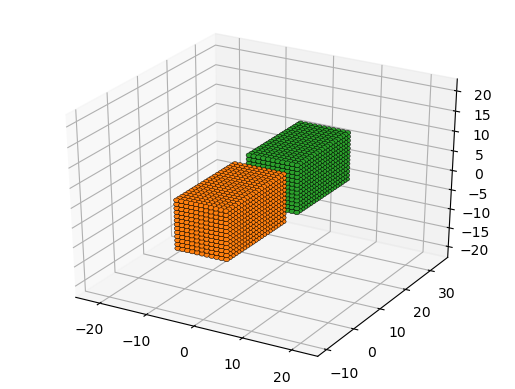

In [11]:
%matplotlib
import kwant
from matplotlib import pyplot
import tinyarray
import numpy as np
import time
from numpy import exp,pi,kron,cos,sin,sqrt,pi,cosh,tanh
from pathos.multiprocessing import Pool 
from scipy import sparse, integrate
from matplotlib import pyplot as plt



sigma0 = np.array([[1,0],[0,1]])
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])

tau0 = sigma0
taux = sigmax
tauy = sigmay
tauz = sigmaz

s0 = sigma0
sx = sigmax
sy = sigmay
sz = sigmaz


Lz =12
Lx=10
Ly=20

bx=2
by=4
bz=2


normal=4
Lsc=(Lz-normal)//2


M = -1.5
A1 = 2
A2 = 2
tx = 1
ty = 1
tz = 1
delta=0.5
mu=0.


pen_len=Lz#100
decay_l=0.2
C0=((pen_len+(Lz//2))/decay_l)/tanh((Lz//2)/decay_l)





def kwant_cubic_conner_TSC_Magnetic_Y(theta,phi):
    
    es = 1e-3
    def sys_shape_J1(pos):
        x,y,z = pos
        return (  -Lx//2-es <x< Lx//2+es and -Ly//2-es <y< Ly//2+es and -es-Lz//2 < z <Lz//2+es )  
    
    def Normal_shape(pos):
        x,y,z = pos
        return (-es-bx//2<x<bx//2+es and Ly//2+es <y< Ly//2+by+es and -es-bz//2 <z< bz+es)
        
    def sys_shape_J2(pos):
        es = 1e-3
        x,y,z = pos
        return (  -Lx//2-es <x< Lx//2+es and Ly//2+by+es <y< 3*Ly//2+by+es and -es-Lz//2 < z <Lz//2+es ) 
    
    def onsite(site,lam_ex,phi_sc):
        x,y,z = site.pos
        if z>=(Lz//2-Lsc):
            h_sc=kron(taux,kron(s0,sigma0))
            Lam_ex=0
        elif z<=-(Lz//2-Lsc):
            h_sc=cos(phi_sc)*kron(taux,kron(s0,sigma0))+sin(phi_sc)*kron(tauy,kron(s0,sigma0))
            Lam_ex=0
        else:
            h_sc=0*kron(taux,kron(s0,sigma0))
            Lam_ex=lam_ex
        onsite_e =((M+2*tx+2*ty+2*tz)*kron(s0,sigmaz)-mu*kron(s0,sigma0))

        zeeman= Lam_ex*(cos(theta)*sin(phi)*kron(sx,sigmaz)+sin(theta)*sin(phi)*kron(sy,sigmaz)\
                        +cos(phi)*kron(sz,sigmaz))
        
        return kron(tauz,onsite_e)+ delta*h_sc+kron(tau0,zeeman)
    
    def hopping_y(site1,site2):
        hopy_e=(-ty*kron(s0,sigmaz)+A2/(2j)*kron(sy,sigmax))
        return kron(tauz,hopy_e)
    
    
    def hopping_x(site1,site2,eta):
        x1,y1,z1 = site1.pos
        x2,y2,z2 = site2.pos
        z=(z1+z2)/2
        hopx_e=(-tx*kron(s0,sigmaz)+A2/(2j)*kron(sx,sigmax))
        phase=eta*(z*pen_len/(Lz//2) + C0*(1/cosh(z/decay_l)**2)*tanh(z/decay_l)*\
                                              ((1/3)*(x2**3-x1**3))/decay_l)
        
#         if z1<=-(Lz//2-Lsc) or z2<=-(Lz//2-Lsc):
#             return kron(tauz,hopx_e)
#         elif z1>=(Lz//2-Lsc) or z2>=(Lz//2-Lsc):
#             return kron(tauz,hopx_e)
#         else:
        return kron(tauz,hopx_e)*cos(2*pi*phase)+1j*kron(tau0,hopx_e)*sin(2*pi*phase)


    def hopping_z(site1,site2,eta):
        x1,y1,z1 = site1.pos
        x2,y2,z2 = site2.pos
        x=(x1+x2)/2

        hopz_e=-tz*kron(s0,sigmaz)+A1/(2j)*kron(sz,sigmax)
        phase=eta*x*C0*decay_l*(tanh(z2/decay_l)-tanh(z1/decay_l))
        
#         if z1<=-(Lz//2-Lsc) or z2<=-(Lz//2-Lsc):
#             return kron(tauz,hopz_e)
#         elif z1>=(Lz//2-Lsc) or z2>=(Lz//2-Lsc):
#             return kron(tauz,hopz_e)
#         else:
        return kron(tauz,hopz_e)*cos(2*pi*phase)+1j*kron(tau0,hopz_e)*sin(2*pi*phase)

    
    lat_S1 = kwant.lattice.cubic(1,norbs=8,name="S1")
    sys = kwant.Builder()
    sys[lat_S1.shape(sys_shape_J1, (1, 1,1))] = onsite
    sys[kwant.builder.HoppingKind((1, 0,0), lat_S1, lat_S1)] = hopping_x
    sys[kwant.builder.HoppingKind((0,1,0), lat_S1, lat_S1)] = hopping_y
    sys[kwant.builder.HoppingKind((0,0,1), lat_S1, lat_S1)] = hopping_z
    
    lat_N = kwant.lattice.cubic(1,norbs=8,name="N")
    sys[lat_N.shape(Normal_shape, (0, Ly//2+1,0))] = onsite
    
    
    
    lat_S2 = kwant.lattice.cubic(1,norbs=8,name="S2")
    sys[lat_S2.shape(sys_shape_J2, (0, Ly,0))] = onsite
    sys[kwant.builder.HoppingKind((1, 0,0), lat_S2, lat_S2)] = hopping_x
    sys[kwant.builder.HoppingKind((0,1,0), lat_S2, lat_S2)] = hopping_y
    sys[kwant.builder.HoppingKind((0,0,1), lat_S2, lat_S2)] = hopping_z
    

    return sys

def kwant_square_system():
    
    def sys_shape(pos):
        es = 1e-3
        x,y = pos
        return (-Lx//2-es <x< Lx//2+es and -Ly//2-es <y< Ly//2+es) 

    
    lat = kwant.lattice.square(1,norbs=4)
    sys = kwant.Builder()
    sys[lat.shape(sys_shape, (1, 1))] = 1
    sys[kwant.builder.HoppingKind((1, 0), lat, lat)] = 1
    sys[kwant.builder.HoppingKind((0,1), lat, lat)] = 1
    return sys
    
    
    
    
    
    
start=time.time()



del_phi=1*pi
eta=del_phi/(2*pi*2*(20//2)*(Lz+2*pen_len))




Phi_sc=1.
system = kwant_cubic_conner_TSC_Magnetic_Y(0,0.5*pi).finalized()
kwant.plot(system)